## GWO & Hail Environment Relationship
##### Dr. Victor Gensini (Fall 2017)
##### Department of Geographic and Atmospheric Sciences
<img style="float:left;height:40px"src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQthtdrc2lZyEOC1iiwubFyvNfzJE7q7_GCTdlFF3peKckmi7cN">

In [1]:
import Ngl, datetime, os, calendar
import numpy as np
import pandas as pd
from netCDF4 import date2num,date2index
from netCDF4 import Dataset
from IPython.display import Image

In [2]:
datadir='/run/media/vgensini/Victor_4TB/narr/scp/' #Location of netCDF data

### GWO data

In [3]:
gwo_file = 'gwo.csv'
gwo_df = pd.read_csv(gwo_file)
formats = '%Y-%m-%d'
gwo_df['date']=pd.to_datetime(gwo_df['date'], format=formats)
gwo_df=gwo_df.set_index(pd.DatetimeIndex(gwo_df['date']))
amp=1
phase=1.5
query='amp>=%s & phase==%s' % (amp,phase)
phase_amp_df = gwo_df.query(query)

### Read in one file to capture lat/lons

In [4]:
nc1 = Dataset('/run/media/vgensini/Victor_4TB/narr/narr_conv/narr_conv_20161201_0000.nc','r',format='NETCDF4_CLASSIC')
lats = nc1.variables["lats"][0][:][:]
lons = nc1.variables["lons"][0][:][:]
nc1.close()

In [5]:
scp_climo = np.empty((0,277,349))
scp_final = np.empty((0,38,277,349))
nc = Dataset('scp_cin_1979_2016.nc','r',format='NETCDF4_CLASSIC')

In [6]:
###############################
#Enter the start and end date:#
######################################
#start_input = '1979110100' #YYYYMMDDHH
#end_input  =  '2016110100' #YYYYMMDDHH
######################################
months=['01','02','03','04','05','06','07','08','09','10','11','12']
for month in months:
    if month=='01' or month=='03' or month=='05' or month=='07' or month=='08' or month=='10' or month=='12':
        emon = 31
    elif month=='04' or month=='06' or month=='09' or month=='11':
        emon = 30
    if month=='02':
        emon = 28
    daycount=1
    while daycount <= emon:
        start_input = '1979'+month+'%02d'%daycount+'21'    #YYYYMMDDHH
        end_input  =  '2016'+month+'%02d'%daycount+'21' #YYYYMMDDHH
        begdate = datetime.datetime.strptime(start_input,"%Y%m%d%H")
        enddate = datetime.datetime.strptime(end_input,"%Y%m%d%H")
        dates = []
        while begdate <= enddate:
            if calendar.isleap(begdate.year) == True:   
                dates.append(begdate)
                begdate+=datetime.timedelta(days=1)
            else:
                dates.append(begdate)
            begdate+=datetime.timedelta(days=365)
        #do things here
        #print dates
        #print len(dates)
        for i,dt in enumerate(dates):
            idex = date2index(dt,nc['time'])
            scp = nc.variables["scp"][idex][:][:]
            cin  = nc.variables["sbcin"][idex][:][:]
            #cin mask
            term5 = np.fabs(cin)
            term5[np.fabs(cin)>50]=0.
            term5[np.fabs(cin)<=50]=1.
            scp = scp * term5
            scp_climo = np.append(scp_climo,[scp],axis=0)
            #print scp_climo.shape
        scp_final=np.append(scp_final,[scp_climo],axis=0)
        scp_climo = np.empty((0,277,349))
        daycount+=1
print scp_final.shape

(365, 38, 277, 349)


In [11]:
#nc.close()
max_scp = np.max(scp_final,axis=0) #Find max SCP value from all the dates
max_scp = np.ndarray.max(max_scp,axis=0)
print max_scp.shape

(277, 349)


### Create a nice plot using PyNGL, an interface to NCL for Python
#### Initialize plot resources

In [12]:
wkres           =  Ngl.Resources()                      #-- generate an resources object for workstation
wkres.wkWidth   =  2500                                 #-- plot resolution 2500 pixel width
wkres.wkHeight  =  2000                                 #-- plot resolution 2000 pixel height
wks_type        = "png"                                 #-- graphics output type
wks             =  Ngl.open_wks(wks_type,"test",wkres)  #-- Open the Ngl canvas for drawing

In [13]:
res                        =  Ngl.Resources()
res.mpFillOn               = True                     # map fill on
res.mpOutlineOn            = True                     # map outline on
res.mpLandFillColor        = "transparent"            # fill land transparent
res.mpOceanFillColor       = "grey"                   # fill ocean grey
res.mpInlandWaterFillColor = "grey"                   # fill inland water grey
res.mpFillDrawOrder        = "PostDraw"               # draw mapfill after contour plot
res.mpGridAndLimbOn        = True                     # turn on gridlines
res.mpProjection           = "LambertConformal"       # set map projection
res.cnLevelSelectionMode   = "ManualLevels"           # set manual contour levels
res.cnMinLevelValF         = 1                        # set contour min value
res.cnMaxLevelValF         = 25                       # set contour max value
res.cnLevelSpacingF        = 1                        # set contour interval
res.cnFillOn               = True                     # turn on contour fill
res.cnLinesOn              = False                    # turn off contour lines
res.cnLineLabelsOn         = False                    # turn off line labels
res.cnFillMode             = "RasterFill"             # These two resources
res.trGridType             = "TriangularMesh"         # can speed up plotting.
res.cnFillPalette          = "precip3_16lev"          # pick a colorbar
res.mpOutlineBoundarySets  = "GeophysicalAndUSStates" # pick map outline boundaries
res.mpLimitMode            = "Corners"                #-- select a sub-region
res.mpLeftCornerLonF       =  -120                    #-- left longitude value
res.mpRightCornerLonF      =  -60                     #-- right longitude value
res.mpLeftCornerLatF       =  20                      #-- left latitude value
res.mpRightCornerLatF      =  50                      #-- right latitude value
res.lbOrientation          = "horizontal"             # colorbar label orientation; default is vertical
res.sfXArray               = lons                     # set array of x values from netCDF longitudes
res.sfYArray               = lats                     # set array of y valyes from netCDF latitudes
res.tiMainString           = "Maximum SCP value (1979-2016)"  # Make a plot title
res.tiMainFontHeightF      = 0.015                    # set plot font title size
res.mpLambertParallel1F    = 33                       # set lambert 1st parallel
res.mpLambertParallel2F    = 45                       # set lambert 2nd parallel
res.mpLambertMeridianF     = -95                      # set lambert centering longitude
plot = Ngl.contour_map(wks,max_scp,res)               # make a countour map
Ngl.end()                                             # close the resources

### Display the image

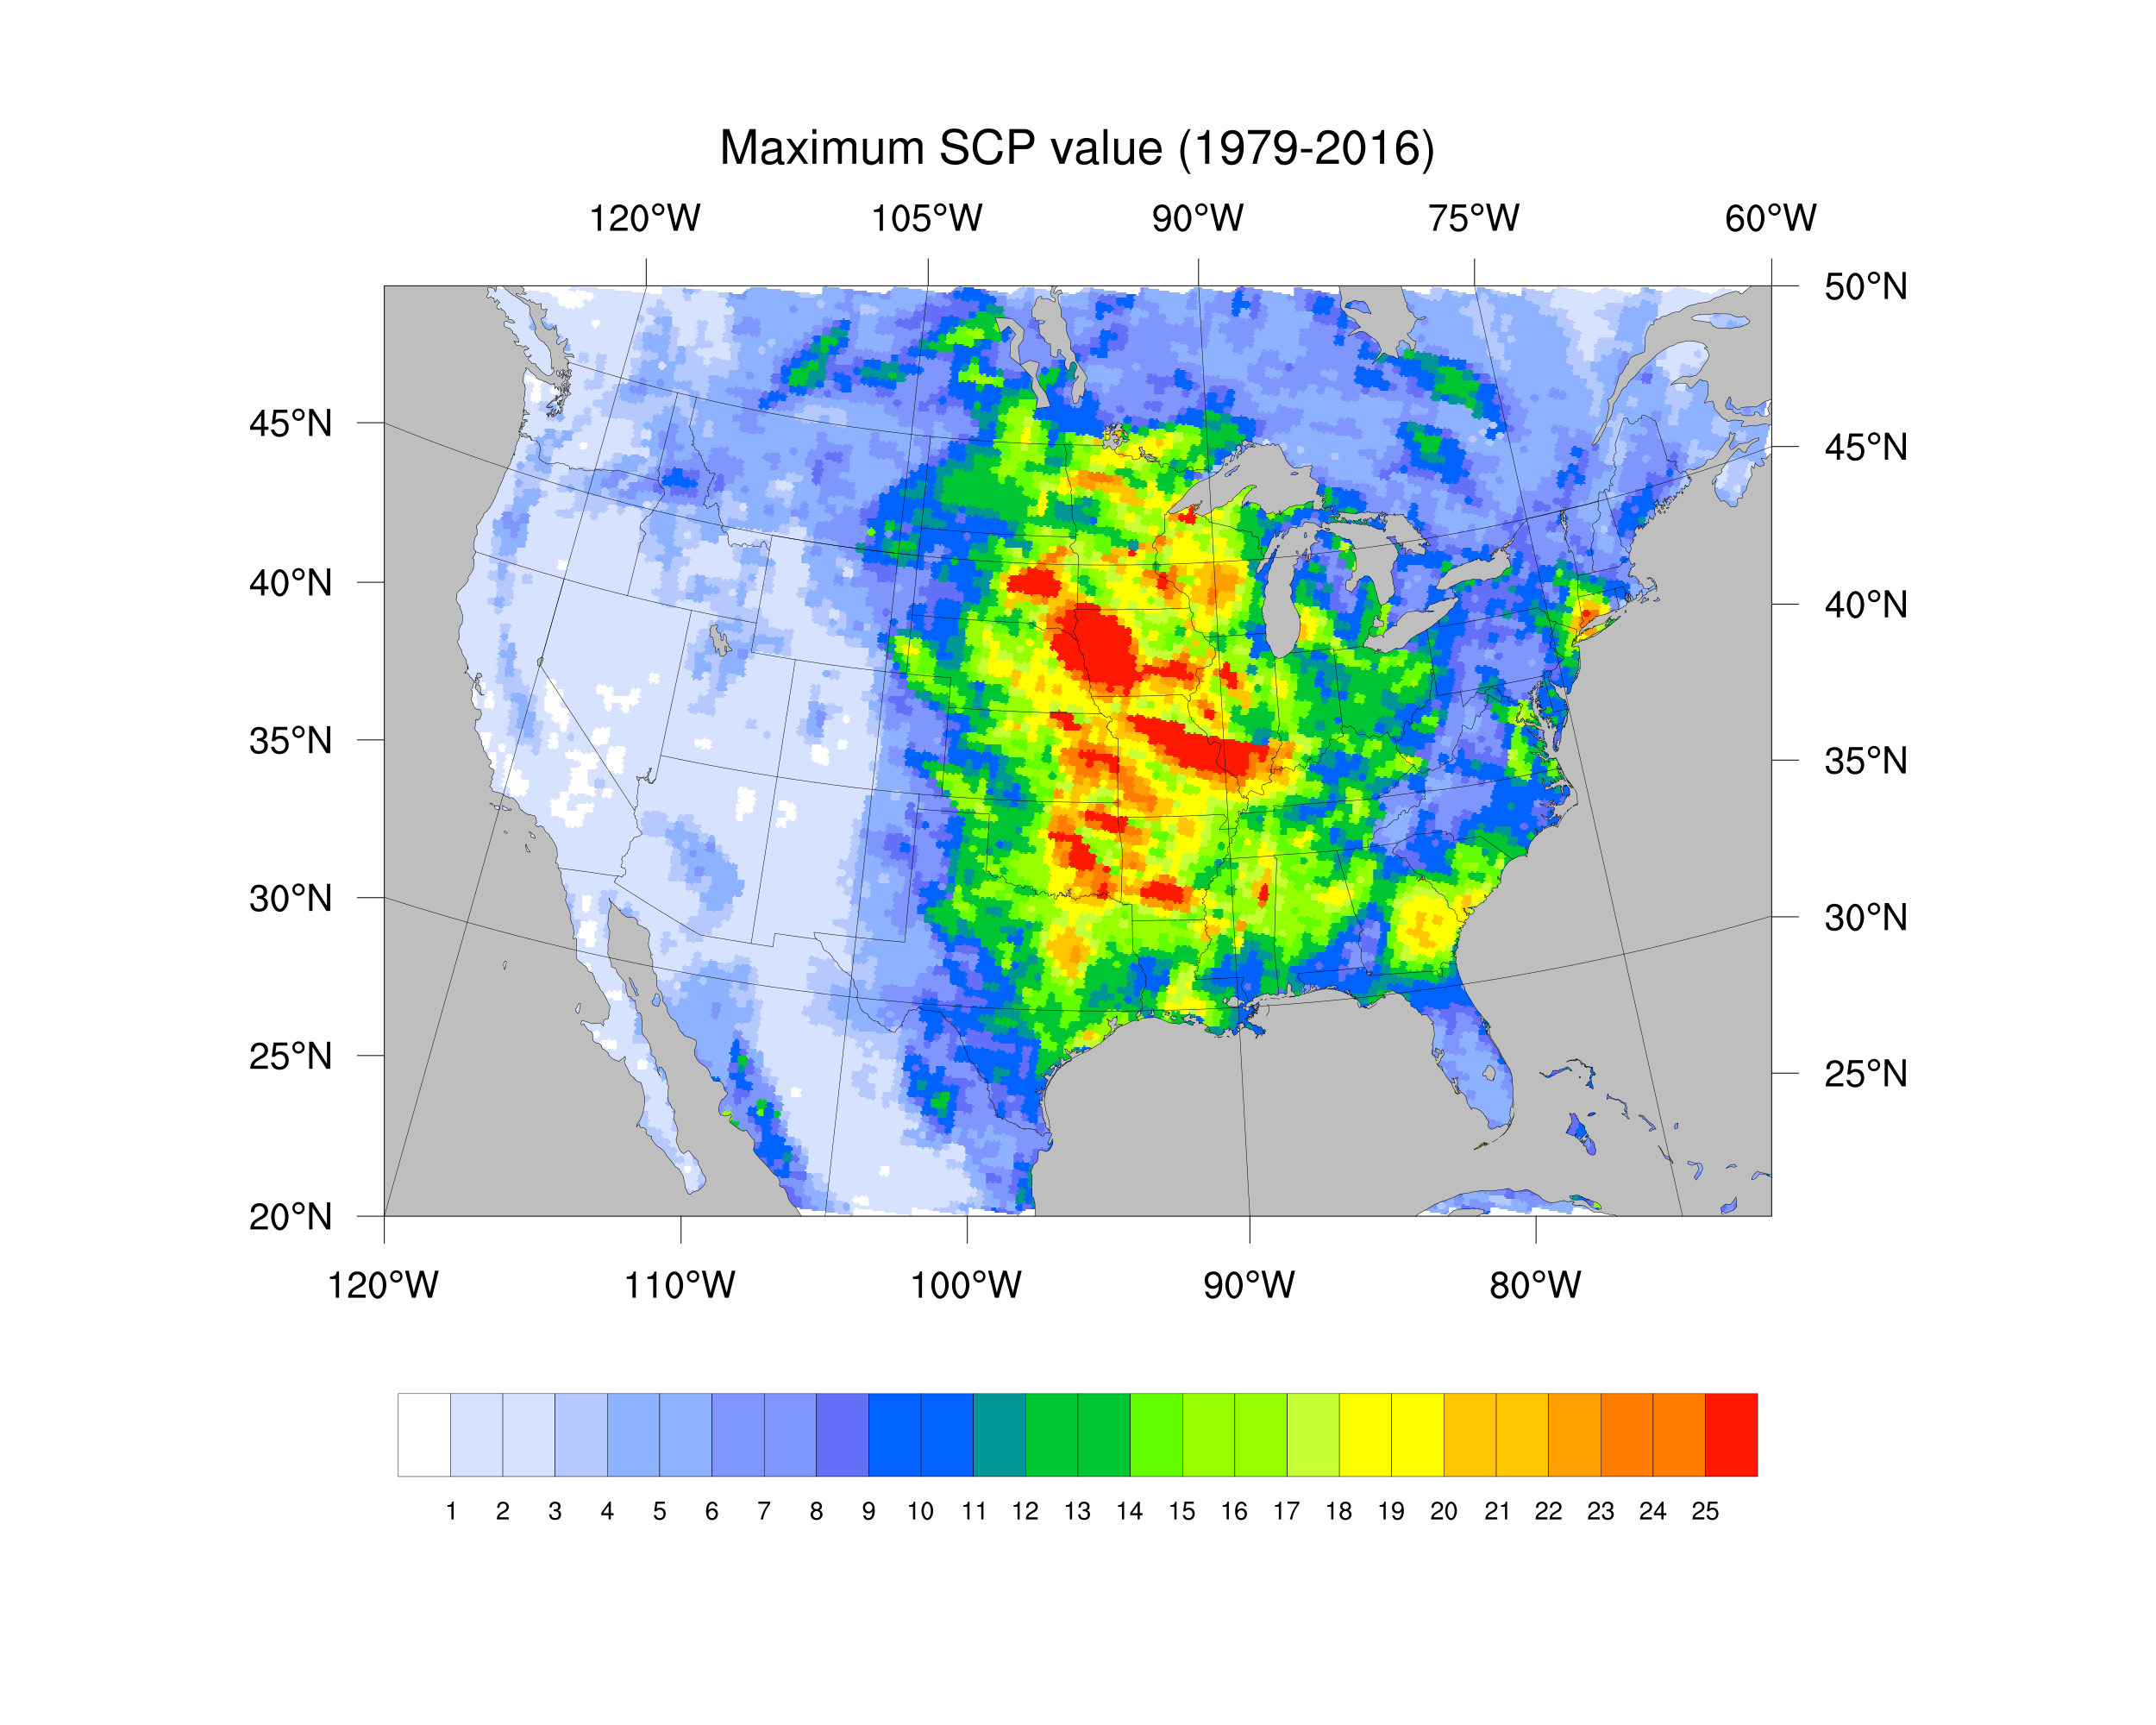

In [14]:
Image(filename='test.png')